In this notebook we will work on a prediction problem of time series data. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

The file was downloaded from http://archive.ics.uci.edu/ml/machine-learning-databases/00235/  
  
The original date has seperated date and time columns, and it would have taken too much time to combine into a datetime after reading. So, we parse them right here.

In [2]:
dt_parser = lambda x, y: pd.datetime.strptime(str(x) + str(y), '%d/%m/%Y%H:%M:%S')
df = pd.read_csv('../input/householdpowerconsumption/household_power_consumption.txt', sep = ';',
                parse_dates={'dt' : ['Date', 'Time']}, date_parser = dt_parser, index_col='dt',
                low_memory=False)
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


* We can see that we have over 2 million rows, so resampling might be needed. 
* Most of the features needs type cast also.

In [4]:
for col in df:
    print(df[col].value_counts(dropna=False))

?         25979
0.218      9565
0.216      9363
0.322      9350
0.324      9304
          ...  
7.726         1
8.214         1
10.290        1
8.784         1
8.134         1
Name: Global_active_power, Length: 4187, dtype: int64
0.000    481561
?         25979
0.100     21902
0.092     21841
0.098     21812
          ...  
1.090         1
1.198         1
1.094         1
1.064         1
1.118         1
Name: Global_reactive_power, Length: 533, dtype: int64
?          25979
241.180     3559
241.120     3289
241.350     3285
241.020     3284
           ...  
252.900        1
253.240        1
252.810        1
253.650        1
253.170        1
Name: Voltage, Length: 2838, dtype: int64
1.000     172785
1.400     164720
1.200     140425
1.600     118212
1.800      95395
           ...  
44.400         1
42.600         1
43.200         1
40.600         1
40.000         1
Name: Global_intensity, Length: 222, dtype: int64
0.000     1880175
1.000       84936
?           25979
2.000       19017
3

We can see that there are 25979 '?'s in the first several columns and an equal amount of "NaN" in the last. Considering the number doesn't make a huge portion in over 2 million, we replace them with mean. 

In [5]:
df.replace('?', np.nan, inplace=True)
for col in df:
    df[col] = df[col].astype(float)
df.fillna(df.mean(), inplace=True)

In [6]:
# Check
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [7]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [8]:
def plot_mean_std(data):
    plt.style.use('seaborn')
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
    ax1.plot(data.index.to_pydatetime(), data['mean'], color= 'b')
    ax2.plot(data.index.to_pydatetime(), data['std'], color= 'g')
    

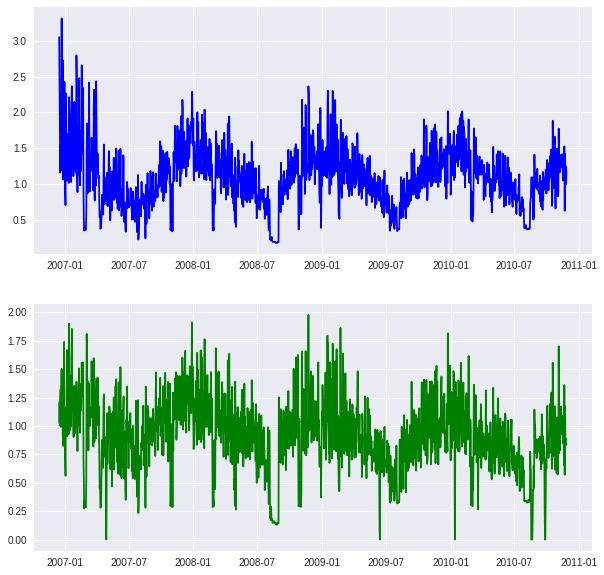

In [9]:
r = df['Global_active_power'].resample('D').agg(['mean', 'std'])
plot_mean_std(r)

Right off the bat, we can tell that there is probably periodicity involved in the data, and the period is a year. To reflect such periodicity over long time, LSTM might be useful.

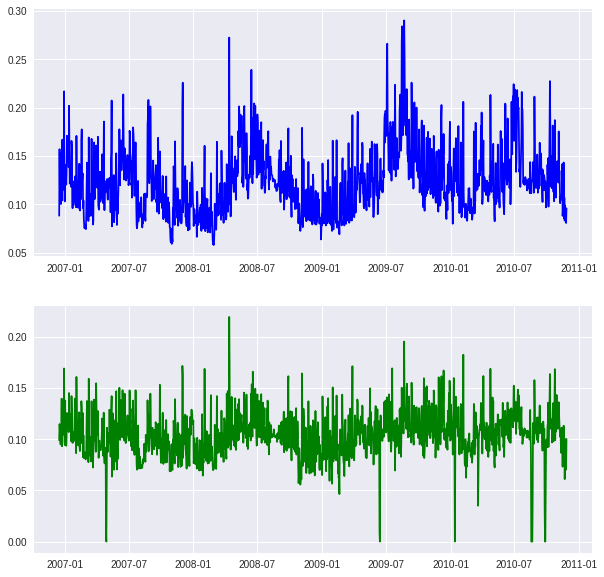

In [10]:
r = df['Global_reactive_power'].resample('D').agg(['mean', 'std'])
plot_mean_std(r)

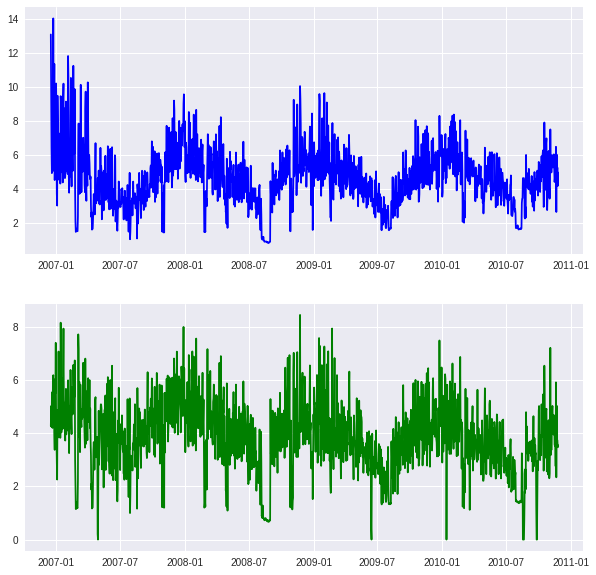

In [11]:
r = df['Global_intensity'].resample('D').agg(['mean', 'std'])
plot_mean_std(r)

So some periodicity in both mean and std of global intensity is also seen. 

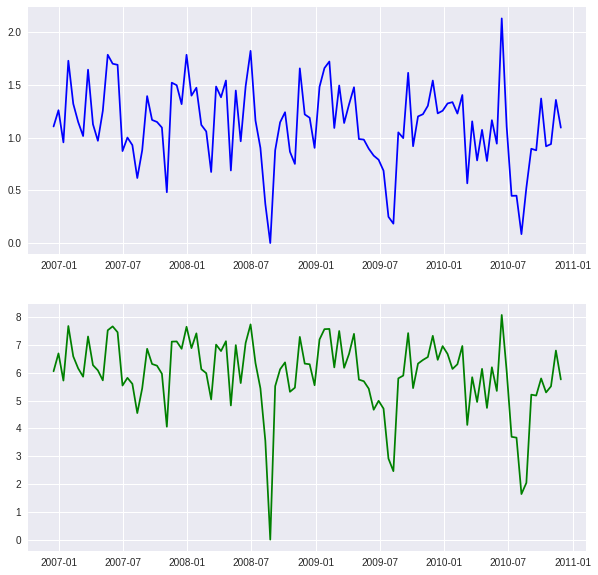

In [12]:
# resample by day too messy. 
sub1 = df['Sub_metering_1'].resample('2W').agg(['mean', 'std'])
plot_mean_std(sub1)

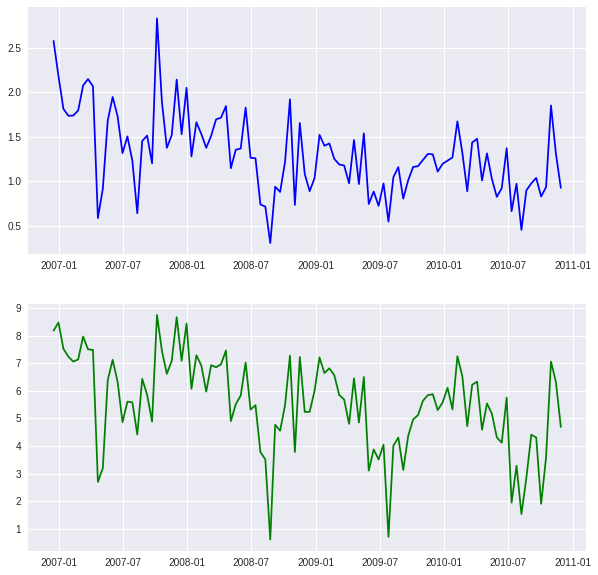

In [13]:
sub2 = df['Sub_metering_2'].resample('2W').agg(['mean', 'std'])
plot_mean_std(sub2)

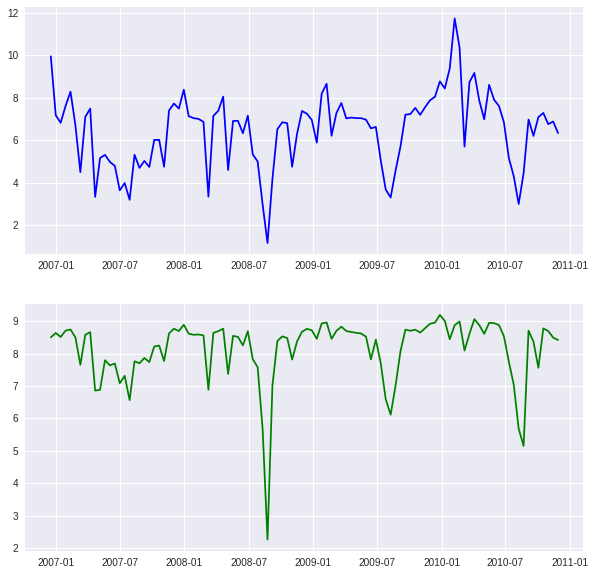

In [14]:
sub3 = df['Sub_metering_3'].resample('2W').agg(['mean', 'std'])
plot_mean_std(sub3)

The up and down trends that starts and ends at July each year are also pretty obvious. But the pattern seems to differ each year for submeterings.  

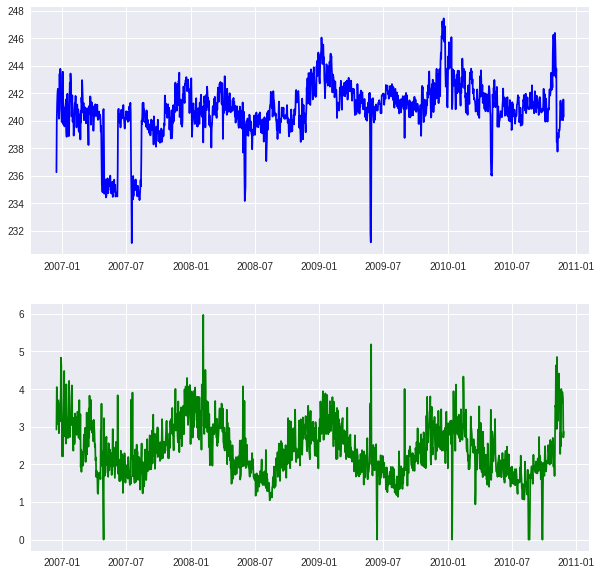

In [15]:
volt = df['Voltage'].resample('d').agg(['mean', 'std'])
plot_mean_std(volt)

Voltage doesn't variate by a lot.

Need to scale the data first as they're in quite different ranges.

In [16]:
# Resample because of the high computational load.
df = df.resample('h').mean()
print(df.shape)

(34589, 7)


In [17]:
values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
df[:] = scaler.fit_transform(values)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418
2006-12-16 18:00:00,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676
2006-12-16 19:00:00,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169
2006-12-16 20:00:00,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809
2006-12-16 21:00:00,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917


In this task, we can define our objective as to predict the global active power of the current timestep, on the basis of the informations of the other 6 variables, and the global active power of the previous timesteps. 

In [70]:
df['GAP next'] = df['Global_active_power'].shift(1)
df.dropna(inplace = True)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,GAP next
dt,,,,,,,,
2006-12-16 22:00:00,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,0.455597
2006-12-16 23:00:00,0.301032,0.092251,0.567188,0.301052,0.0,0.001795,0.000000,0.322555
2006-12-17 00:00:00,0.273201,0.132286,0.580314,0.273434,0.0,0.010050,0.000000,0.301032
2006-12-17 01:00:00,0.501108,0.176840,0.560615,0.492946,0.0,0.543431,0.000000,0.273201
2006-12-17 02:00:00,0.227338,0.101033,0.766632,0.228360,0.0,0.012204,0.000000,0.501108


Let's use all data except for the last year as training set, and the last year as the test set.

In [71]:
train = df[:'2009-07-01 00:00:00'].values 
test = df['2009-07-01 00:00:00':].values
print(train.shape, test.shape)

(22251, 8) (12334, 8)


In [72]:
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]

In [73]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [74]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error

In [80]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               69632     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y), shuffle=False)
y_hat = model.predict(test_X)

Epoch 1/50
174/174 [==============================] - 2s 11ms/step - loss: 0.0149 - val_loss: 0.0084
Epoch 2/50
174/174 [==============================] - 1s 8ms/step - loss: 0.0110 - val_loss: 0.0081
Epoch 3/50
174/174 [==============================] - 2s 9ms/step - loss: 0.0106 - val_loss: 0.0081
Epoch 4/50
174/174 [==============================] - 1s 8ms/step - loss: 0.0104 - val_loss: 0.0080
Epoch 5/50
174/174 [==============================] - 1s 8ms/step - loss: 0.0104 - val_loss: 0.0080
Epoch 6/50
174/174 [==============================] - 1s 8ms/step - loss: 0.0103 - val_loss: 0.0080
Epoch 7/50
174/174 [==============================] - 1s 8ms/step - loss: 0.0103 - val_loss: 0.0080
Epoch 8/50
174/174 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0079
Epoch 9/50
174/174 [==============================] - 1s 9ms/step - loss: 0.0102 - val_loss: 0.0080
Epoch 10/50
174/174 [==============================] - 2s 9ms/step - loss: 0.0102 - val_loss: 0.007

In [77]:
test_X = test_X.reshape((test_X.shape[0], 7))

# invert scaling for y_hat
y_hat_x = np.concatenate((y_hat, test_X[:, 1:]), axis=1)
y_hat_x = scaler.inverse_transform(y_hat_x)
inv_y_hat = y_hat_x[:,0]

# invert scaling for the original test value
test_y = test_y.reshape((test_y.shape[0], 1))
test_y_x = np.concatenate((test_y, test_X[:, 1:]), axis=1)
test_y_x = scaler.inverse_transform(test_y_x)
inv_y = test_y_x[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_hat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.560


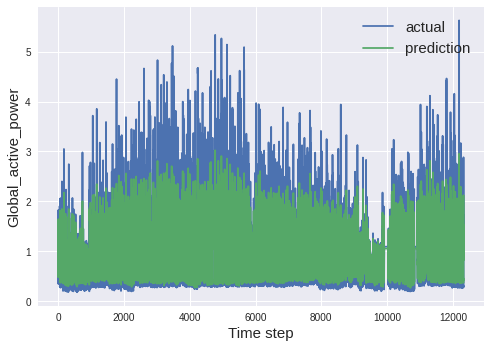

In [85]:
x = range(inv_y.shape[0])
plt.plot(x, inv_y, label="actual")
plt.plot(x, inv_y_hat, label="prediction")
plt.ylabel('Global_active_power', size = 15)
plt.xlabel('Time step', size = 15)
plt.legend(fontsize=15)
plt.show()

As I increase the number of epochs and change other hyperparameters (without using grid search), the result matches marginally better. Somehow the prediction are better at the beginning and the end phase of the period, but underpredicts in the period. 